### University of Washington: Machine Learning and Statistics 

# Lecture 14: Autoencoders

Andrew Connolly and Stephen Portillo

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 9.8.5
- [astroML website](https://www.astroml.org/index.html)
- [Deep Learning](https://www.deeplearningbook.org/) by Goodfellow, Bengio, and Courville, Chapter 14 (free to read online!)
- [Understanding Variational Autoencoders](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) by Joseph Rocca
- [Making New Layers and Models via Subclassing](https://keras.io/guides/making_new_layers_and_models_via_subclassing/) from the `keras` documentation

This notebook is developed based on material from A. Connolly, Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, Killian Weinberger and many others.

The notebook and associated material are available from [github](https://github.com/uw-astro/astr-598a-win22).

Make sure you are using the latest version of astroML

In [1]:
pip install --pre -U astroml

Note: you may need to restart the kernel to use updated packages.


We'll also need to update `tensorflow` to the latest version:

In [2]:
pip install -U tensorflow

Note: you may need to restart the kernel to use updated packages.


Run this cell to confirm you've got `tensorflow` version 2.8.0 (you may have to restart the kernel). If you're on the class JupyterHub, you can ignore the `cudart` warning because we're not using a GPU.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

2022-03-02 07:35:30.020898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 07:35:30.020956: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.8.0


We'll also use KerasTuner for hyperparameter tuning.

In [4]:
pip install -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np

import matplotlib.pyplot as plt

from astroML.datasets import sdss_corrected_spectra

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import keras_tuner as kt

### Rest-Frame SDSS Spectra

We'll use the `astroML` set of 1000 SDSS galaxy spectra that have been shifted to the rest frame and infilled with iterative PCA. The dataset has quiescent and star forming galaxies, as well as some AGNs.

In [6]:
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

class_idx = [2, 3, 4, 5, 6]
class_names = ['absorption galaxy', 'galaxy', 'emission galaxy', 'narrow-line AGN', 'broad-line AGN']

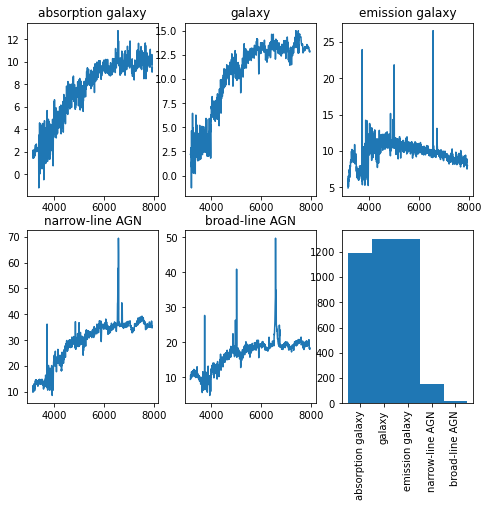

In [7]:
plt.figure(figsize=(8,7))
for i in range(len(class_idx)):
    plt.subplot(2, 3, i+1)
    j = np.where(data['lineindex_cln'] == class_idx[i])[0][0]
    plt.plot(wavelengths, spectra[j])
    plt.title(class_names[i])
plt.subplot(2, 3, 6)
plt.hist(data['lineindex_cln'], bins=np.arange(6)-0.5+2)
plt.xticks(class_idx, class_names, rotation=90)
plt.show()

To help our neural network train, we'll normalize the spectra by their L1 norms - for most spectra, this is equivalent to making the average pixel flux 1 in each spectrum. For a small number of spectra with significant negative pixels, using the L1 norm rather than the sum avoids dividing by a number close to zero. We'll also subtract out the mean spectrum, which has a mix of quiescent and star forming properties.

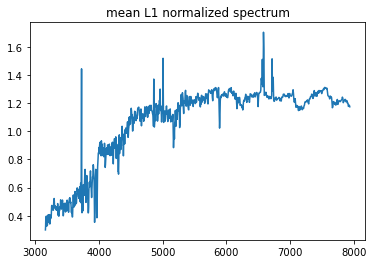

In [8]:
spectranorms = np.mean(np.abs(spectra), axis=1)
normedspectra = spectra / spectranorms[:, None]

meanspectrum = np.mean(normedspectra, axis=0)
normedspectra -= meanspectrum

plt.plot(wavelengths, meanspectrum)
plt.title('mean L1 normalized spectrum')
plt.show()

In [9]:
(X_train, X_valid) = train_test_split(normedspectra, train_size=0.9, random_state=0)

### Autoencoders

An **autoencoder** is a neural network that consists of two parts: an **encoder** that takes in input data and outputs it to a **latent vector** and a **decoder** that reconstructs the data from the latent vector. In an **undercomplete autoencoder**, the network must learn how to compress and reconstruct information because the latent vector is lower dimensional than the data. By training this network to minimize the difference between reconstruction and input on a training set, the network learns a compression that is tailored to that specific training set, and the latent vectors hold useful information about each data point.

If the encoder and decoder are fully connected layers with linear activation functions and the mean squared error loss function is used, the optimal autoencoder with $k$ elements will project inputs onto $k$ vectors that have the same span as the first $k$ PCA eigenvectors. In this way, autoencoders can be thought of as a non-linear generalization of PCA dimensionality reduction.

<img src="https://miro.medium.com/max/1400/1*bY_ShNK6lBCQ3D9LYIfwJg@2x.png" width="50%"/>

from [Understanding Variational Autoencoders](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) by Joseph Rocca

In [10]:
input_dim = X_train.shape[1]
hidden_dim = 40
latent_dim = 2

# Define encoder model.
original_inputs = tf.keras.Input(shape=(input_dim,), name="encoder_input")
x = layers.Dense(hidden_dim, activation="relu")(original_inputs)
z = layers.Dense(latent_dim, activation="linear", name="z")(x)
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z")
x = layers.Dense(hidden_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(input_dim, activation="linear", name="reconstruction")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

# Define autoencoder model.
outputs = decoder(z)
autoencoder = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="autoencoder")

encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 40)                40040     
                                                                 
 z (Dense)                   (None, 2)                 82        
                                                                 
Total params: 40,122
Trainable params: 40,122
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z (InputLayer)              [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 40

2022-03-02 07:35:39.446428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-02 07:35:39.446477: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-02 07:35:39.446504: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-sportill): /proc/driver/nvidia/version does not exist
2022-03-02 07:35:39.446799: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
autoencoder.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.RootMeanSquaredError()],
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=1e-4,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=10,
        verbose=1,
    )
]

history = autoencoder.fit(
    X_train,
    X_train,
    batch_size=128,
    epochs=100,
    validation_data=(X_valid, X_valid),
    callbacks=callbacks
)

Epoch 1/100
29/29 [==============================] - 1s 11ms/step - loss: 0.0512 - root_mean_squared_error: 0.2262 - val_loss: 0.0460 - val_root_mean_squared_error: 0.2144 - lr: 0.0010
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0259 - root_mean_squared_error: 0.1608 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1609 - lr: 0.0010
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1507 - lr: 0.0010
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0165 - root_mean_squared_error: 0.1286 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1482 - lr: 0.0010
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1474 - lr: 0.0010
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0155

### Reconstructions and Latent Space

We can look at how well our autoencoder with a latent vector of 2 elements does at reconstructing spectra compared to PCA with two components. By design, the autoencoder must do at least as well as PCA, and seems to always deliver improved reconstructions. The AGN are the hardest spectra to reconstruct for both, and the autoencoder seems to give the best fractional improvement on the emission galaxies.

In [12]:
latentAE = encoder.predict(normedspectra)
reconAE = decoder.predict(latentAE)

specPCA = PCA(latent_dim)
coeffPCA = specPCA.fit_transform(normedspectra)
reconPCA = specPCA.inverse_transform(coeffPCA)

In [13]:
AE_RMSE = []
PCA_RMSE = []

for i in range(len(class_idx)):
    match = (data['lineindex_cln'] == class_idx[i])
    AE_RMSE.append(np.sqrt(np.mean((normedspectra[match] - reconAE[match])**2)))
    PCA_RMSE.append(np.sqrt(np.mean((normedspectra[match] - reconPCA[match])**2)))

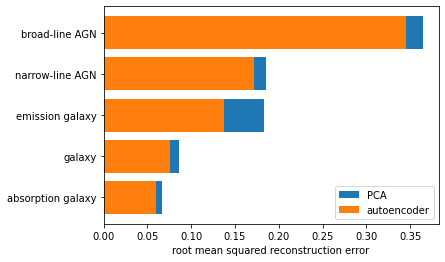

In [14]:
plt.barh(class_idx, PCA_RMSE, tick_label=class_names, label='PCA')
plt.barh(class_idx, AE_RMSE, tick_label=class_names, label='autoencoder')
plt.legend()
plt.xlabel('root mean squared reconstruction error')
plt.show()

Both PCA coefficient space and latent space seem to arrange the different classes of galaxy in similar ways. Note that unlike the PCA coefficients, the autoencoder components do not come in order of importance!

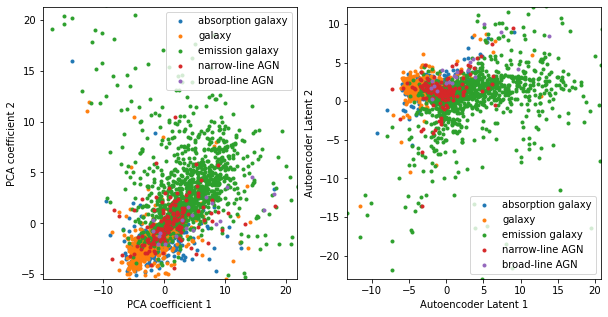

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for i in range(5):
    match = (data['lineindex_cln'] == class_idx[i])
    plt.scatter(coeffPCA[match,0], coeffPCA[match,1], s=9, label=class_names[i])
plt.xlim(np.percentile(coeffPCA[:,0], 0.5), np.percentile(coeffPCA[:,0], 99.5))
plt.ylim(np.percentile(coeffPCA[:,1], 0.5), np.percentile(coeffPCA[:,1], 99.5))
plt.xlabel('PCA coefficient 1')
plt.ylabel('PCA coefficient 2')
plt.legend()

plt.subplot(1,2,2)
for i in range(5):
    match = (data['lineindex_cln'] == class_idx[i])
    plt.scatter(latentAE[match,0], latentAE[match,1], s=9, label=class_names[i])
plt.xlim(np.percentile(latentAE[:,0], 0.5), np.percentile(latentAE[:,0], 99.5))
plt.ylim(np.percentile(latentAE[:,1], 0.5), np.percentile(latentAE[:,1], 99.5))
plt.xlabel('Autoencoder Latent 1')
plt.ylabel('Autoencoder Latent 2')
plt.legend()
plt.show()

To interpret PCA, we can look at the PCA components to see what combination of continuum and line changes it is picking up on. Interpreting the autoencoder is more difficult because it is non-linear. However, we can see what it is doing locally by taking derivatives of the reconstruction with respect to the elements of the latent vector. These derivatives look similar to the PCA components, but more noisy because they are not being constrained by all spectra in the training set like the PCA components are. Note that we are evaluating these derivatives at $(0,0)$ in latent space, and they will change if we choose a different location.

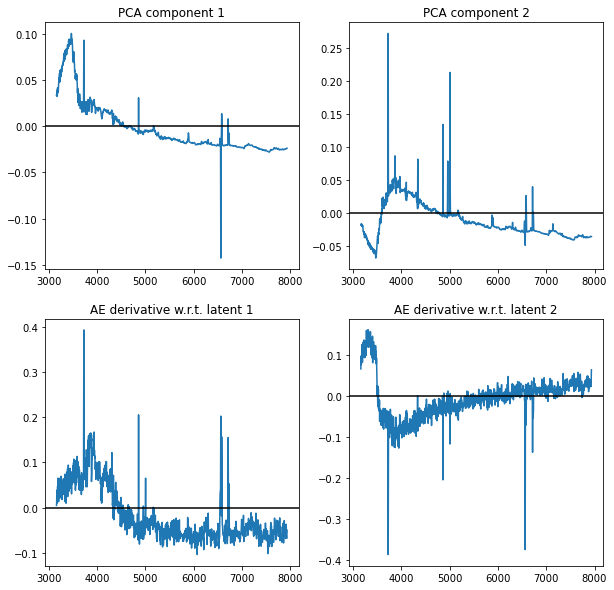

In [16]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(wavelengths, specPCA.components_[0])
plt.axhline(0, c='k')
plt.title('PCA component 1')
plt.subplot(2,2,2)
plt.plot(wavelengths, specPCA.components_[1])
plt.axhline(0, c='k')
plt.title('PCA component 2')

# calculate derivatives of reconstructions wrt latent parameters
with tf.GradientTape() as t:
    z = tf.Variable(tf.zeros((1, latent_dim)))
    synthspec = decoder(z)
    ae_derivatives = t.jacobian(synthspec, z)

    plt.subplot(2,2,3)
    plt.plot(wavelengths, ae_derivatives[0,:,0,0])
    plt.axhline(0, c='k')
    plt.title('AE derivative w.r.t. latent 1')
    plt.subplot(2,2,4)
    plt.plot(wavelengths, ae_derivatives[0,:,0,1])
    plt.axhline(0, c='k')
    plt.title('AE derivative w.r.t. latent 2')
    plt.show()

### Regularizing Latent Space

It would be useful if we could think of the space of possible latent vectors as a latent space that our spectra occupy. However, autoencoders don't guarantee that this latent space will be **regular**. That is, an autoencoder may be irregular where:
- dissimilar inputs can get encoded to closeby points in latent space
- points in latent space that are between training points may not decode to anything meaningful

Instead, we would like a latent space where:
- points that are nearby in latent space decode to similar reconstructions
- points in latent space that are between training points decode physically meaningful interpolations

<img src="https://miro.medium.com/max/1400/1*83S0T8IEJyudR_I5rI9now@2x.png">

from [Understanding Variational Autoencoders](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) by Joseph Rocca

### Variational Autoencoders

In a **variational autoencoder**, input data are not mapped to single points in latent space, but rather a distribution. The idea is that dissimilar inputs can't be mapped to arbitrarily close points in latent space, and similar inputs will be encouraged to have their distributions overlap:

<img src="https://miro.medium.com/max/1400/1*79AzftDm7WcQ9OfRH5Y-6g@2x.png" width="50%" />

from [Understanding Variational Autoencoders](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) by Joseph Rocca


In practice, the most common distribution used are independent Gaussians for each dimension of latent space, characterized by a mean $\mu$ and variance $\sigma$. The encoder then outputs a mean and log variance for each latent dimension. Instead of figuring out how to transform a Gaussian with non-linear tranformations, the decoder samples $z$ from the Gaussians defined by the encoder and feeds that through to arrive at a reconstruction. Thus, the autoencoder is no longer deterministic, but returns decoded samples from the encoded Gaussian distribution. To help regularize the latent space, the KL divergence between the encoded distribution and the standard Gaussian is added as a regularization term.

<img src="https://miro.medium.com/max/1400/1*Q5dogodt3wzKKktE0v3dMQ@2x.png" width="50%" />

from [Understanding Variational Autoencoders](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) by Joseph Rocca

The name variational autoencoder comes from variational inference - if the decoder is taken as a forward model where we want to infer the latent parameters, the loss function is a log likelihood, and we use a standard Gaussian prior, the Gaussians that the encoder produces are the best Gaussian approximation to the posterior. If all of the pixel fluxes had Gaussian errors of variance 1, the sum of squared errors would be the log likelihood. However, we don't have error bars for our spectra; if we assume each pixel has similar error bars, the mean squared error is some multiple of the log likelihood. With this motivation, we'll suppress the KL divergence term by a factor $\beta$ that doesn't hurt reconstruction too much.

In [17]:
# custom layer to sample from Gaussians with given means and log variances
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [18]:
input_dim = normedspectra.shape[1]
hidden_dim = 40
latent_dim = 2
beta = 0.001

# Define encoder model.
original_inputs = tf.keras.Input(shape=(input_dim,), name="encoder_input")
x = layers.Dense(hidden_dim, activation="relu")(original_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder_vae = tf.keras.Model(inputs=original_inputs, outputs=(z_mean, z_log_var), name="encoder")

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(hidden_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(input_dim, name="reconstruction")(x)
decoder_vae = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

# Define VAE model.
z = Sampling()((z_mean, z_log_var))
outputs = decoder_vae(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

# Add KL divergence regularization loss.
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(beta * kl_loss) # suppress by beta in the loss function
vae.add_metric(kl_loss, name='KLD') # display full KL divergence in metrics

encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 40)                40040     
                                                                 
 z (Dense)                   (None, 2)                 82        
                                                                 
Total params: 40,122
Trainable params: 40,122
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z (InputLayer)              [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 40

In [19]:
vae.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.RootMeanSquaredError()],
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=1e-4,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=10,
        verbose=1,
    )
]

history = vae.fit(
    X_train,
    X_train,
    batch_size=128,
    epochs=100,
    validation_data=(X_valid, X_valid),
    callbacks=callbacks
)

Epoch 1/100
29/29 [==============================] - 1s 12ms/step - loss: 0.0567 - root_mean_squared_error: 0.2356 - KLD: 1.2309 - val_loss: 0.0458 - val_root_mean_squared_error: 0.2040 - val_KLD: 3.9070 - lr: 0.0010
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0288 - root_mean_squared_error: 0.1576 - KLD: 4.0106 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1638 - val_KLD: 4.0135 - lr: 0.0010
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0228 - root_mean_squared_error: 0.1381 - KLD: 3.6559 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1575 - val_KLD: 3.5395 - lr: 0.0010
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0213 - root_mean_squared_error: 0.1341 - KLD: 3.3212 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1543 - val_KLD: 3.3679 - lr: 0.0010
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0206 - root_mean_squared_error: 0.1322 - KLD: 3.1248 - val_l

In [20]:
latentVAE, latentVAE_logvar = encoder_vae.predict(normedspectra)
reconVAE = decoder_vae.predict(latentVAE) # reconstruct using mean only, so it's deterministic

### Regularized Latent Space
We can check that the VAE is still doing about the same as the autoencoder at reconstruction. The latent space looks similar, but notice that the regularization term has encouraged the encodings to not wander too far away from $(0,0)$.

In [21]:
VAE_RMSE = []

for i in range(len(class_idx)):
    match = (data['lineindex_cln'] == class_idx[i])
    VAE_RMSE.append(np.sqrt(np.mean((normedspectra[match] - reconVAE[match])**2)))

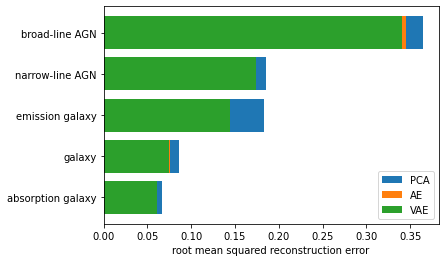

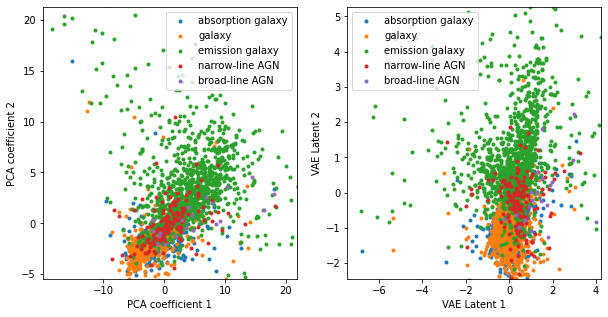

In [22]:
plt.barh(class_idx, PCA_RMSE, tick_label=class_names, label='PCA')
plt.barh(class_idx, AE_RMSE, tick_label=class_names, label='AE')
plt.barh(class_idx, VAE_RMSE, tick_label=class_names, label='VAE')
plt.legend()
plt.xlabel('root mean squared reconstruction error')
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for i in range(5):
    match = (data['lineindex_cln'] == class_idx[i])
    plt.scatter(coeffPCA[match,0], coeffPCA[match,1], s=9, label=class_names[i])
plt.xlim(np.percentile(coeffPCA[:,0], 0.5), np.percentile(coeffPCA[:,0], 99.5))
plt.ylim(np.percentile(coeffPCA[:,1], 0.5), np.percentile(coeffPCA[:,1], 99.5))
plt.xlabel('PCA coefficient 1')
plt.ylabel('PCA coefficient 2')
plt.legend()

plt.subplot(1,2,2)
for i in range(5):
    match = (data['lineindex_cln'] == class_idx[i])
    plt.scatter(latentVAE[match,0], latentVAE[match,1], s=9, label=class_names[i])
plt.xlim(np.percentile(latentVAE[:,0], 0.5), np.percentile(latentVAE[:,0], 99.5))
plt.ylim(np.percentile(latentVAE[:,1], 0.5), np.percentile(latentVAE[:,1], 99.5))
plt.xlabel('VAE Latent 1')
plt.ylabel('VAE Latent 2')
plt.legend()
plt.show()

In a variational autoencoder, there is a way to roughly rank the importance of each latent component by looking at the log variance assigned to each component. Smaller log variances mean that the network wanted to constrain that component more, so it must be more important. The derivatives agree well with the PCA components, and look less noisy than the autoencoder derivatives, as nearby spectra are helping to constrain these derivatives.

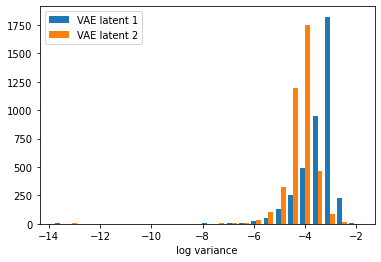

In [23]:
plt.hist(latentVAE_logvar, label=['VAE latent 1', 'VAE latent 2'], histtype='bar', bins=25)
plt.xlabel('log variance')
plt.legend()
plt.show()

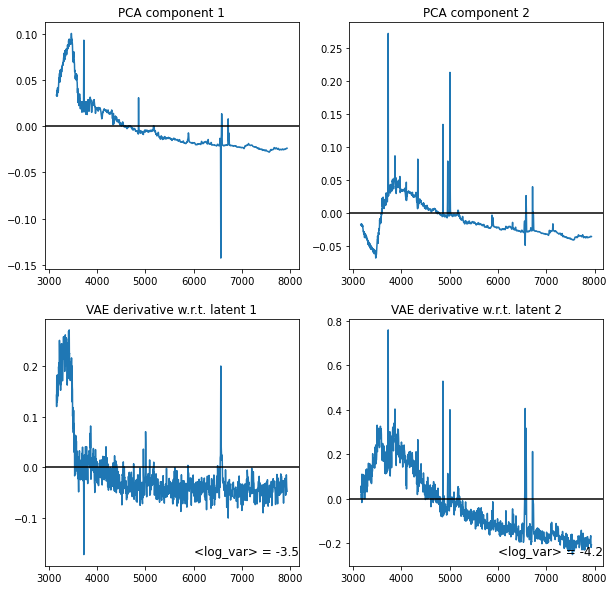

In [24]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(wavelengths, specPCA.components_[0])
plt.axhline(0, c='k')
plt.title('PCA component 1')
plt.subplot(2,2,2)
plt.plot(wavelengths, specPCA.components_[1])
plt.axhline(0, c='k')
plt.title('PCA component 2')

# calculate derivatives of reconstructions wrt latent parameters
with tf.GradientTape() as t:
    z = tf.Variable(tf.zeros((1, latent_dim)))
    synthspec = decoder_vae(z)
    ae_derivatives = t.jacobian(synthspec, z)

    plt.subplot(2,2,3)
    plt.plot(wavelengths, ae_derivatives[0,:,0,0])
    plt.axhline(0, c='k')
    plt.title('VAE derivative w.r.t. latent 1')
    plt.text(6000, np.min(ae_derivatives[0,:,0,0]), '<log_var> = %0.1f' % np.mean(latentVAE_logvar[:,0]), fontsize='large')
    plt.subplot(2,2,4)
    plt.plot(wavelengths, ae_derivatives[0,:,0,1])
    plt.axhline(0, c='k')
    plt.title('VAE derivative w.r.t. latent 2')
    plt.text(6000, np.min(ae_derivatives[0,:,0,1]), '<log_var> = %0.1f' % np.mean(latentVAE_logvar[:,1]), fontsize='large')
    plt.show()

We can interpolate between training examples by interpolating in latent space. We don't simply get a linear interpolation of the spectra, but an interpolation that looks physically meaningful with spectral lines appearing, and the continuum and line ratios changing.

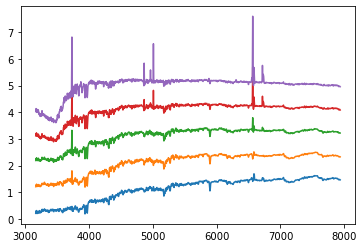

In [25]:
z_absorption = latentVAE[3, :].reshape(1,-1)
z_emission = latentVAE[16, :].reshape(1,-1)

for i in range(5):
    f = i / 4.
    plt.plot(wavelengths, decoder_vae.predict((1-f) * z_absorption + f * z_emission)[0] + meanspectrum + i)
plt.show()

### Exercise
Try increasing $\beta$ in the variational autoencoder above - how are the reconstruction error and latent space affected?

### Hyperparameter Tuning

We have to make choose many hyperparameters when putting together a neural network. Once we have an architecture we think will work, a common way to choose hyperparameters is with **hyperparameter tuning**. `keras_tuner` is well-integrated with `keras`, and one way to use it is to make a function that builds and trains a model based on hyperparameters and returns the loss function we want to minimize.

In [26]:
def build_and_train_model(hidden_dim=40, batch_size=128):
    input_dim = normedspectra.shape[1]
    latent_dim = 2
    beta = 0.001

    # Define encoder model.
    original_inputs = tf.keras.Input(shape=(input_dim,), name="encoder_input")
    x = layers.Dense(hidden_dim, activation="relu")(original_inputs)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    encoder_vae = tf.keras.Model(inputs=original_inputs, outputs=(z_mean, z_log_var), name="encoder")

    # Define decoder model.
    latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(hidden_dim, activation="relu")(latent_inputs)
    outputs = layers.Dense(input_dim, name="reconstruction")(x)
    decoder_vae = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

    # Define VAE model.
    z = Sampling()((z_mean, z_log_var))
    outputs = decoder_vae(z)
    vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

    # Add KL divergence regularization loss.
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae.add_loss(beta * kl_loss) # suppress by beta in the loss function
    vae.add_metric(kl_loss, name='KLD') # display full KL divergence in metrics
    
    vae.compile(
        # Optimizer
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        # Loss function to minimize
        loss=keras.losses.MeanSquaredError(),
        # List of metrics to monitor
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=5,
            verbose=1,
            min_delta=1e-4,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-4,
            patience=10,
            verbose=1,
        )
    ]

    history=autoencoder.fit(
        X_train,
        X_train,
        batch_size=batch_size,
        epochs=100,
        validation_data=(X_valid, X_valid),
        callbacks=callbacks
    )
        
    recon = vae.predict(X_valid)
    return {'default_objective': np.std(X_valid - recon)}

The simplest tuning strategy is **random search**, where we establish bounds for each hyperparameter, and then just choose randomly from within those bounds.

In [27]:
class MyTuner(kt.RandomSearch):
    def run_trial(self, trial, **kwargs):
        hp = trial.hyperparameters
        return build_and_train_model(
            hidden_dim=hp.Int("hidden_dim", 8, 256, step=8),
            batch_size=hp.Int("batch_size", 32, 512, step=32),
        )

tuner = MyTuner(
    max_trials=10, overwrite=True, directory="kt_demo", project_name="VAE",
)
tuner.search()

Trial 10 Complete [00h 00m 02s]
default_objective: 0.29619407653808594

Best default_objective So Far: 0.28512415289878845
Total elapsed time: 00h 00m 22s
INFO:tensorflow:Oracle triggered exit


In [28]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp['hidden_dim'], best_hp['batch_size'])

240 448
